In [360]:
import itertools
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml


In [ ]:
def demand_function(price, c, d):
    """
    Demand function based on price elasticity parameters.

    See: https://www.econstor.eu/bitstream/10419/286380/1/1856454916.pdf for
        an example of the log function.
    """
    return np.exp(c * np.log(price) + d)

def estimate_demand_params(p1, q1, p2, q2):
    """
    Estimate the demand function parameters c and d using linear regression
    on the log-log transformed data.

    """
    A = np.array([[np.log(p1), 1],
                  [np.log(p2), 1]])
    b = np.array([np.log(q1), np.log(q2)])
    c, d = np.linalg.solve(A, b)
    return c, d


class Tariff:
    def __init__(self, volumetric_prices, fixed_charge, market_prices):
        """
        :param array volumetric_prices: tariff prices in each hour ($/kWh)
        :param float fixed_charge: fixed charge
        :param array market_prices: market prices in each hour ($/kWh)
        """
        self.volumetric_prices = np.array(volumetric_prices)
        self.fixed = fixed_charge
        self.market_prices = np.array(market_prices)

    def consumption(self, customer):
        """
        :param Customer customer: Customer class to calculate consumption for.
        :return: kWh consumption in each hour.
        """
        consumed = []
        for hour, price in enumerate(self.volumetric_prices):
           kwh = customer.demand(hour, price)
           consumed.append(kwh)
        return np.array(consumed)

    def bill(self, customer):
        """
        Calculate how much the customer gets charged.
        """
        consumed = self.consumption(customer)
        return self.fixed + sum(consumed * self.volumetric_prices)

    def complexity(self):
        """
        Calculate the complexity of the tariff by counting the number
        of price tiers.
        """
        return len(np.unique(self.volumetric_prices))

    def utility_cost(self, customer):
        """
        Cost to the utility for the tariff.
        """
        return sum(self.consumption(customer) * self.market_prices)

    def __str__(self):
        return f'Tariff(fixed={self.fixed}, prices={self.volumetric_prices})'

    def catalog_key(self):
        """
        Create a unique key for cataloging tariffs.
        """
        prices_str = '_'.join(f'{p:.2f}' for p in self.volumetric_prices)
        return f'fixed_{self.fixed:.2f}_prices_{prices_str}'


class Customer:
    """
    Model of a customer class.
    """
    def __init__(self, base_consumptions, base_prices, elasticities=-0.1):
        """
        :param array base_consumptions: base consumptions in each hour block (kWh)
        :param array base_prices: base prices in each hour block ($/kWh)
        :param array elasticities: price elasticities in each hour block
        """
        self.base_consumption = np.array(base_consumptions, dtype=float)
        self.base_prices = np.array(base_prices, dtype=float)
        self.elasticities = np.array(elasticities, dtype=float)
        if np.isscalar(self.elasticities):
            self.elasticities = np.full_like(self.base_consumption,
                                             self.elasticities)
        # calculate c and d components of demand function for each hour by
        # perturbing the base consumption based on reported elasticities
        p1 = self.base_prices.copy()
        q1 = self.base_consumption.copy()
        p2 = self.base_prices * 1.01  # increase price by 1%
        q2 = q1 * (1 + self.elasticities * 0.01)
        self.c = np.zeros_like(self.base_consumption, dtype=float)
        self.d = np.zeros_like(self.base_consumption, dtype=float)
        for hour in range(len(self.base_consumption)):
            c, d = estimate_demand_params(p1[hour], q1[hour],
                                          p2[hour], q2[hour])
            self.c[hour] = c
            self.d[hour] = d

    def demand(self, hour, price):
        """
        Calculate demand in kWh for a given hour and price.
        """
        c = self.c[hour]
        d = self.d[hour]
        return demand_function(price, c, d)


In [158]:
prices = np.array([20, 35, 40, 85, 30]) / 1000  # $/kWh
# Use same consumption shape
# Profile from https://doi-org.libproxy.mit.edu/10.5547/01956574.43.1.akar
# Approximation of Figure C2
consumption = np.array([1, 1.4, 1, 1.7, 1.2]) * 4  # kWh in each timeslot
# Make class B more elastic than class A
classA = Customer(base_consumptions=consumption,
                  base_prices=np.full_like(prices, 0.05),
                  elasticities=-0.03)
classB = Customer(base_consumptions=consumption,
                  base_prices=np.full_like(prices, 0.05),
                  elasticities=-0.1)

In [159]:
print("total daily consumption (kWh)", consumption.sum())

total daily consumption (kWh) 25.2


Tariff A bill for class A: 5.767735253963696
Tariff A bill for class B: 5.795845135636699
Tariff B bill for class A: 3.252223794555526
Tariff B bill for class B: 3.2443434524705834


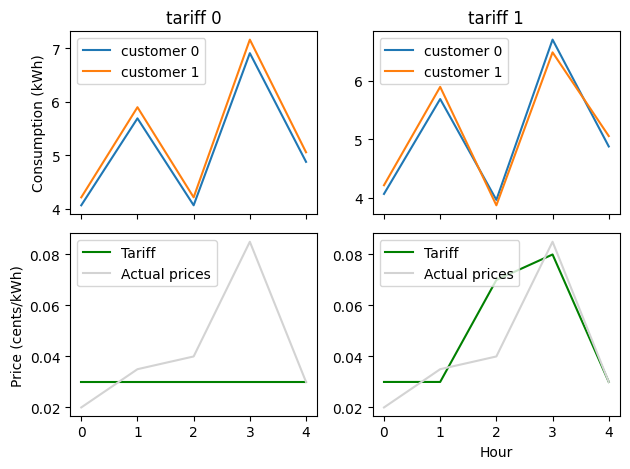

In [160]:
# Create some different tariffs and evaluate their impact on consumptions.

# Prices in dollars per kWh
tariffA = Tariff(
    volumetric_prices=np.array([30, 30, 30, 30, 30]) / 1000,
    fixed_charge=5,
    market_prices=prices
)
tariffB = Tariff(
    volumetric_prices=np.array([30, 30, 70, 80, 30]) / 1000,
    fixed_charge=2,
    market_prices=prices
)

print("Tariff A bill for class A:", tariffA.bill(classA))
print("Tariff A bill for class B:", tariffA.bill(classB))
print("Tariff B bill for class A:", tariffB.bill(classA))
print("Tariff B bill for class B:", tariffB.bill(classB))

# Make 2x2 plot of hourly consumption for classA and classB under
# tariff A and tariff B


fig, axs = plt.subplots(2, 2, sharex=True, sharey=False)
for i, tariff in enumerate([tariffA, tariffB]):
    for j, customer in enumerate([classA, classB]):
        consumption = tariff.consumption(customer)
        axs[0, i].plot(np.arange(len(consumption)), consumption, label=f'customer {j}')
        axs[0, i].set_title(f'tariff {i}')
        # Plot tariff prices
    axs[1, i].plot(np.arange(len(tariff.volumetric_prices)),
                    tariff.volumetric_prices, label='Tariff', color='green')
    # Plot the actual prices in a light grey
    axs[1, i].plot(np.arange(len(prices)), prices, label='Actual prices', color='lightgrey')
    axs[0, i].legend()
    axs[1, i].legend()
axs[0, 0].set_ylabel('Consumption (kWh)')
axs[1, 0].set_ylabel('Price (cents/kWh)')
plt.xlabel('Hour')

plt.tight_layout()



In [364]:
def make_tariff_set(prices, base_consumptions_A, base_consumptions_B,
                    base_prices_A, base_prices_B, elasticities_A,
                    elasticities_B, n_customers_A=1, n_customers_B=1,
                    fixed_charges=None, volumetric_prices=None,
                    n_prices_daily=2):
    """
    Make and evaluate a set of tariffs over the given information.

    :param array prices: market prices in each hour ($/kWh)
    :param array base_consumptions_A: base consumptions for class A
    :param array base_consumptions_B: base consumptions for class B
    :param array base_prices_A: base prices for class A matching base
        consumptions_A
    :param array base_prices_B: base prices for class B matching base
        consumptions_B
    :param array elasticities_A: price elasticities for class A
    :param array elasticities_B: price elasticities for class B
    :param int n_customers_A: number of customers for class A
    :param int n_customers_B: number of customers for class B
    :param array fixed_charges: list of possible fixed charges for each tariff
    :param array volumetric_prices: list of possible volumetric prices for
        the tariff
    :param int n_prices_daily: maximum number of allowable prices per day
    """
    if elasticities_A > 0 or elasticities_B > 0:
        raise ValueError("Elasticities must be negative.")

    tariff_book = []

    output = []
    if fixed_charges is None:
        fixed_charges = np.array([0])
    n_volumetric_prices = volumetric_prices.shape[0]
    n_fixed_charges = len(fixed_charges)
    customer_A = Customer(base_consumptions_A, base_prices_A,
                          elasticities_A)
    customer_B = Customer(base_consumptions_B, base_prices_B,
                          elasticities_B)

    total_combos = (
        n_volumetric_prices * n_volumetric_prices *
        n_fixed_charges * n_fixed_charges
    )
    print(f"Generating {total_combos} tariffs...")
    count = 0
    iterate = 0
    start = time.monotonic()
    for a_volume, b_volume, a_fix, b_fix in itertools.product(
                                     range(n_volumetric_prices),
                                     range(n_volumetric_prices),
                                     range(n_fixed_charges),
                                     range(n_fixed_charges)):
        iterate += 1
        a_volumetric_prices = volumetric_prices[a_volume, :]
        b_volumetric_prices = volumetric_prices[b_volume, :]
        if np.unique(a_volumetric_prices).size > n_prices_daily:
            continue
        elif np.unique(b_volumetric_prices).size > n_prices_daily:
            continue
        # Don't consider tariffs where the on-peak period is in the first
        # or the last time block.
        elif a_volumetric_prices[0] > a_volumetric_prices[1]:
            continue
        elif b_volumetric_prices[0] > b_volumetric_prices[1]:
            continue
        elif a_volumetric_prices[-1] > a_volumetric_prices[-2]:
            continue
        elif b_volumetric_prices[-1] > b_volumetric_prices[-2]:
            continue

        a_fixed = fixed_charges[a_fix]
        b_fixed = fixed_charges[b_fix]

        tariff_A = Tariff(a_volumetric_prices, a_fixed, prices)
        tariff_B = Tariff(b_volumetric_prices, b_fixed, prices)

        tariff_result = {}

        # record the revenue from customers, complexity, energy cost, and the
        # fraction of peak load corresponding to customer A.
        tariff_result['revenue_A'] = tariff_A.bill(customer_A) * n_customers_A
        tariff_result['revenue_B'] = tariff_B.bill(customer_B) * n_customers_B
        tariff_result['complexity_A'] = tariff_A.complexity()
        tariff_result['complexity_B'] = tariff_B.complexity()
        tariff_result['energy_cost_A'] = tariff_A.utility_cost(customer_A) * n_customers_A
        tariff_result['energy_cost_B'] = tariff_B.utility_cost(customer_B) * n_customers_B

        consumption_A = tariff_A.consumption(customer_A) * n_customers_A
        consumption_B = tariff_B.consumption(customer_B) * n_customers_B
        peak_hour_system = np.argmax(consumption_A + consumption_B)
        frac_peak_A = (
            consumption_A[peak_hour_system] /
            (consumption_A + consumption_B)[peak_hour_system]
        )
        tariff_result['fixedfracA'] = frac_peak_A
        # Insert leading zeros to make the tariff id 10 digits.
        tariff_id = f"T{count:010d}"
        tariff_result['tariff_id'] = tariff_id
        tariff_result['energy_A_kWh'] = consumption_A
        tariff_result['energy_B_kWh'] = consumption_B
        for h in range(volumetric_prices.shape[1]):
            tariff_result[f'T{h}_kWh'] = consumption_A[h] + consumption_B[h]

        output.append(tariff_result)
        tariff_book.append(
            np.concatenate([
                a_volumetric_prices,
                [a_fixed],
                b_volumetric_prices,
                [b_fixed],
            ])
        )
        count += 1
        if count % 20000 == 0:
            print(f"Generated {count} of {total_combos} tariffs...")
            elapsed = time.monotonic() - start
            print("Elapsed time: ", elapsed, "seconds")
            print("Estimated time to completion: ",
                  round((total_combos - iterate) * elapsed / iterate, 2), "seconds")

    print("Valid tariffs: ", len(output))
    print("Done.")

    return output, pd.DataFrame(
        tariff_book, columns=['A0', 'A1', 'A2', 'A3', 'A4', 'Afixed',
                              'B0', 'B1', 'B2', 'B3', 'B4', 'Bfixed'])


In [367]:
# Assume consumptions are reported under a price of 0.1 $/kWh
base_prices = np.full_like(prices, 0.05)

# Create all possible combinations of volumetric prices
price_options = np.arange(0.05, 0.26, 0.1)
# Cycle through price options and create all combinations
volumetric_prices = []

for sequence in itertools.product(price_options, repeat=5):
    volumetric_prices.append(np.array(sequence))
volumetric_prices = np.array(volumetric_prices)

fixed_charges = [25, 50]

tariff_set, tariff_book = make_tariff_set(prices, base_consumptions_A=consumption,
                base_consumptions_B=consumption,
                base_prices_A=base_prices, base_prices_B=base_prices,
                elasticities_A=-0.03, elasticities_B=-0.1,
                n_customers_A=100, n_customers_B=100,
                fixed_charges=fixed_charges,
                volumetric_prices=volumetric_prices)

Generating 236196 tariffs...
Valid tariffs:  10404
Done.


In [368]:
def outcomes(revenue_A, revenue_B, energy_cost_A, energy_cost_B, fixedfracA,
             fixed_cost):
    """
    Calculate the expected outcomes such as the cross subsidy, fixed costs
    which the tariff will support, and recovery rate...
    """
    subsidy = xsubsidy(revenue_A, energy_cost_A, fixedfracA, fixed_cost)

    recovery = recovery_rate(energy_cost_A, energy_cost_B, fixed_cost,
                                  revenue_A, revenue_B)

    return subsidy, recovery

def xsubsidy(revenue, purchase_cost, fixed_cost_frac, fixed_cost):
    # If subsidy is negative, it means that the group is underpaying
    # relative to the services received
    return revenue - purchase_cost - fixed_cost_frac * fixed_cost

def recovery_rate(cost_A, cost_B, cost_fixed, revenue_A, revenue_B):
    return (revenue_A + revenue_B) / (cost_A + cost_B + cost_fixed) - 1





In [369]:
# For each tariff, evaluate the outcomes.
tariff_outcomes = []
fixed_costs_to_recover = [10 * 500, 20 * 1000]
for tariff, fixed_cost in itertools.product(tariff_set, fixed_costs_to_recover):
    tariff_outcomes.append(tariff.copy())
    subsidy, recovery = outcomes(
        tariff['revenue_A'], tariff['revenue_B'], tariff['energy_cost_A'],
        tariff['energy_cost_B'], tariff['fixedfracA'], fixed_cost
    )
    tariff_outcomes[-1]['combo-id'] = f"{tariff['tariff_id']}-{fixed_cost}"
    tariff_outcomes[-1]['fixed_cost'] = fixed_cost
    tariff_outcomes[-1]['subsidy'] = subsidy
    tariff_outcomes[-1]['recovery'] = recovery
    tariff_outcomes[-1]['total_complexity'] = tariff['complexity_A'] + tariff['complexity_B']
tariff_outcomes_df = pd.DataFrame(tariff_outcomes)
# Drop the columns which are arrays
tariff_outcomes_df = tariff_outcomes_df.drop(columns=['energy_A_kWh', 'energy_B_kWh'])
tariff_outcomes_df.set_index('combo-id', inplace=True)
tariff_outcomes_df.head()

,revenue_A,revenue_B,complexity_A,complexity_B,energy_cost_A,energy_cost_B,fixedfracA,tariff_id,T0_kWh,T1_kWh,T2_kWh,T3_kWh,T4_kWh,fixed_cost,subsidy,recovery,total_complexity
combo-id,,,,,,,,,,,,,,,,,
T0000000000-5000,2627.560035,2627.560035,1,1,114.813352,114.813352,0.5,T0000000000,842.164165,1179.029831,773.387045,1297.223345,1010.596998,5000,12.746683,0.004875,2
T0000000000-20000,2627.560035,2627.560035,1,1,114.813352,114.813352,0.5,T0000000000,842.164165,1179.029831,773.387045,1297.223345,1010.596998,20000,-7487.253317,-0.740227,2
T0000000001-5000,2627.560035,5127.560035,1,1,114.813352,114.813352,0.5,T0000000001,842.164165,1179.029831,773.387045,1297.223345,1010.596998,5000,12.746683,0.482920,2
T0000000001-20000,2627.560035,5127.560035,1,1,114.813352,114.813352,0.5,T0000000001,842.164165,1179.029831,773.387045,1297.223345,1010.596998,20000,-7487.253317,-0.616645,2
T0000000002-5000,5127.560035,2627.560035,1,1,114.813352,114.813352,0.5,T0000000002,842.164165,1179.029831,773.387045,1297.223345,1010.596998,5000,2512.746683,0.482920,2


5025.493365736336
10943.057576187495


Text(0.5, 0, 'Supported fixed charges (USD)')

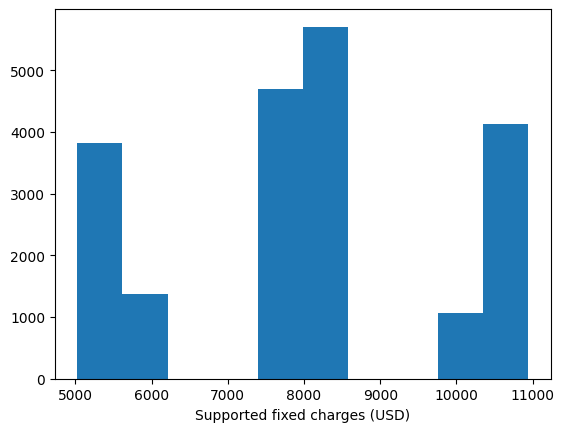

In [372]:
fixed_charges_supported = (
    tariff_outcomes_df['revenue_A'] + tariff_outcomes_df['revenue_B'] -
    tariff_outcomes_df['energy_cost_A'] - tariff_outcomes_df['energy_cost_B']
)
plt.hist(fixed_charges_supported)

print(fixed_charges_supported.min())
print(fixed_charges_supported.max())
plt.xlabel('Supported fixed charges (USD)')

Text(0.5, 0, 'CO2 intensity (g)')

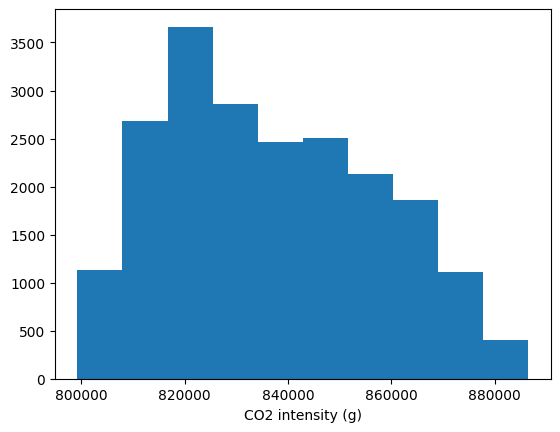

In [371]:
# Plot CO2 intensity of each of the tariffs.
hourly_co2 = [200, 100, 30, 250, 250]
intensity = (tariff_outcomes_df['T0_kWh'] * hourly_co2[0] +
    tariff_outcomes_df['T1_kWh'] * hourly_co2[1] +
    tariff_outcomes_df['T2_kWh'] * hourly_co2[2] +
    tariff_outcomes_df['T3_kWh'] * hourly_co2[3] +
    tariff_outcomes_df['T4_kWh'] * hourly_co2[4])

plt.hist(intensity)
plt.xlabel('CO2 intensity (g)')


In [379]:
tariff_outcomes_df.columns

Index(['revenue_A', 'revenue_B', 'complexity_A', 'complexity_B',
       'energy_cost_A', 'energy_cost_B', 'fixedfracA', 'tariff_id', 'T0_kWh',
       'T1_kWh', 'T2_kWh', 'T3_kWh', 'T4_kWh', 'fixed_cost', 'subsidy',
       'recovery', 'total_complexity'],
      dtype='object')

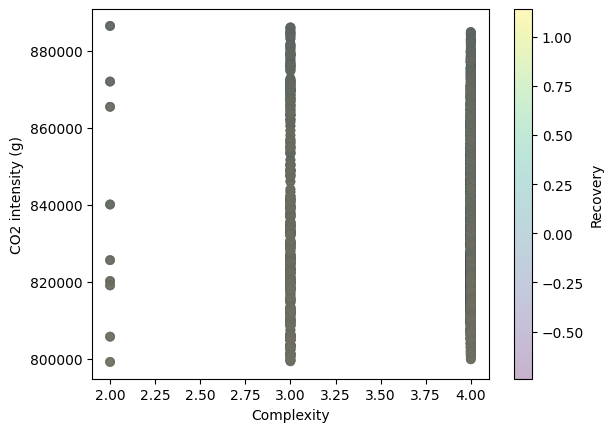

In [385]:
# Make scatterplot of complexity vs. CO2 intensity. and color by recovery.
plt.scatter(tariff_outcomes_df['total_complexity'], intensity,
            c=tariff_outcomes_df['recovery'], cmap='viridis',
            alpha=0.3)
plt.xlabel('Complexity')
plt.ylabel('CO2 intensity (g)')
plt.colorbar(label='Recovery')


In [389]:
# Write to the yaml format for the catalog.

def to_mcdp_catalog(tariff_set, filepath, nmax=1000):
    catalog = {}
    catalog['F'] = ['USD', 'USD']
    catalog['R'] = [
        'dimensionless', 'dimensionless', 'USD', 'USD', 'dimensionless',
        'kWh', 'kWh', 'kWh', 'kWh', 'kWh']
    catalog['implementations'] = {}

    total = len(tariff_set)
    for i, tariff in enumerate(tariff_set):
        if i % 5000 == 0 and i > 0:
            print(f"Generating tariff {i+1} of {total}...")
            print(tariff)
        info = {}
        info['f_max'] = [
            f"{float(tariff['revenue_A']):.4f} USD",
            f"{float(tariff['revenue_B']):.4f} USD"]
        info['r_min'] = [
            f"{float(tariff['complexity_A'])} dimensionless",
            f"{float(tariff['complexity_B'])} dimensionless",
            f"{float(tariff['energy_cost_A']):.4f} USD",
            f"{float(tariff['energy_cost_B']):.4f} USD",
            f"{float(tariff['fixedfracA']):.5f} dimensionless",
            f"{float(tariff['T0_kWh']):.4f} kWh",
            f"{float(tariff['T1_kWh']):.4f} kWh",
            f"{float(tariff['T2_kWh']):.4f} kWh",
            f"{float(tariff['T3_kWh']):.4f} kWh",
            f"{float(tariff['T4_kWh']):.4f} kWh",
        ]
        catalog['implementations'][tariff['tariff_id']] = info
        if i >= nmax:
            break

    with open(filepath, 'w') as f:
        yaml.dump(catalog, f)


fpath = '../tariff_design.mcdplib/tariff/tariff.dpc.yaml'

to_mcdp_catalog(tariff_set,
                filepath=fpath,
                nmax=100000)


Generating tariff 5001 of 10404...
{'revenue_A': np.float64(2785.3710698502837), 'revenue_B': np.float64(2745.3693268702623), 'complexity_A': 2, 'complexity_B': 2, 'energy_cost_A': np.float64(112.07011783042643), 'energy_cost_B': np.float64(110.15710020368033), 'fixedfracA': np.float64(0.49171879317991374), 'tariff_id': 'T0000005000', 'energy_A_kWh': array([407.36106428, 570.30548999, 386.69352238, 627.47657101,
       505.29849882]), 'energy_B_kWh': array([377.04438738, 527.86214234, 346.25225903, 648.61167233,
       505.29849882]), 'T0_kWh': np.float64(784.405451658082), 'T1_kWh': np.float64(1098.1676323213278), 'T2_kWh': np.float64(732.9457814157925), 'T3_kWh': np.float64(1276.0882433417623), 'T4_kWh': np.float64(1010.596997633904)}
Generating tariff 10001 of 10404...
{'revenue_A': np.float64(3060.5706106065286), 'revenue_B': np.float64(2682.24621542655), 'complexity_A': 2, 'complexity_B': 2, 'energy_cost_A': np.float64(109.59850667793063), 'energy_cost_B': np.float64(109.047526083